<a href="https://colab.research.google.com/github/inachenyx/SpeechSNN/blob/main/Speech_SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 5.7 MB/s eta 0:00:00


In [3]:
import os
import io
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF

### Upload data from local files (NEEDS MANUAL UPLOAD)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving ae.train to ae.train
Saving ae.test to ae.test
Saving size_ae.train to size_ae.train
Saving size_ae.test to size_ae.test


In [8]:
# List uploaded files
os.listdir()

['.config',
 'ae.test',
 'ae.train',
 'size_ae.test',
 'size_ae.train',
 'sample_data']

### Read original data (has type bytes)

In [6]:
with open("ae.train", "rb") as f:
    train_bytes = f.read()

with open("ae.test", "rb") as f:
    test_bytes = f.read()

with open("size_ae.train", "rb") as f:
    train_counts_bytes = f.read()

with open("size_ae.test", "rb") as f:
    test_counts_bytes = f.read()

print(train_bytes[:100]) # bytes containing space-separated float values
print(type(train_bytes)) # <class 'bytes'> raw bytes
print(test_bytes[:100])
print(type(test_bytes)) # <class 'bytes'> raw bytes
print(train_counts_bytes)
print(type(train_counts_bytes)) # <class 'bytes'> raw bytes
print(test_counts_bytes)
print(type(test_counts_bytes)) # <class 'bytes'> raw bytes

b'1.860936 -0.207383 0.261557 -0.214562 -0.171253 -0.118167 -0.277557 0.025668 0.126701 -0.306756 -0.2'
<class 'bytes'>
b'1.635533 0.024848 0.432087 -0.361914 -0.074776 -0.693481 -0.229621 0.261503 -0.089421 -0.020431 -0.0'
<class 'bytes'>
b'30 30 30 30 30 30 30 30 30\n'
<class 'bytes'>
b'31 35 88 44 29 24 40 50 29 \n'
<class 'bytes'>


### Get train_counts, test_counts (how many utterances belong to each speaker)

In [7]:
def byte_to_list(byte_data):
  """Decode label counts from raw bytes data to a list of integers

    Args:
        byte_data (bytes): data read from size_ae.train, size_ae.test

    Returns:
        List[int]: the decoded label counts
    """
  text = byte_data.decode("utf-8")
  list_str = text.strip().split()
  list_fl = [int(x) for x in list_str]
  # list_fl = list(map(int, list_str))
  return list_fl

train_counts = byte_to_list(train_counts_bytes)
test_counts = byte_to_list(test_counts_bytes)
print(train_counts)
print(test_counts)

[30, 30, 30, 30, 30, 30, 30, 30, 30]
[31, 35, 88, 44, 29, 24, 40, 50, 29]


### Get Latency Encoded Tensors

In [9]:
def prepare_spike_data(byte_data, label_counts):
    """Parses raw byte input, assigns speaker labels, pads sequences, and normalizes.

    Args:
        - byte_data (bytes): raw byte input read from ae.train, ae.test
        - label_counts (List[int]): each element represents how many blocks belong to a speaker

    Returns:
        - torch.Tensor of shape (N, 12, T): padded and normalized data
        - torch.Tensor of shape (N,): speaker labels
        - int: maximum sequence length (T)
    """
    text = byte_data.decode("utf-8")
    blocks = [b.strip() for b in text.strip().split("\n\n") if b.strip()]

    data_blocks = []
    labels = []

    for speaker_id, count in enumerate(label_counts, start=1):
        for idx in range(count):
            lines = blocks[idx].splitlines()
            frame_data = [list(map(float, line.strip().split())) for line in lines]
            data_blocks.append(np.array(frame_data))  # shape (Ti, 12)
            labels.append(speaker_id)

    latency_encoded_blocks = []
    Tmax = max([block.shape[0] for block in data_blocks])  # maximum time steps

    for block in data_blocks:
        block = block.T  # shape (12, T)
        avg = np.mean(block)
        binary_block = (block >= avg).astype(np.float32)  # binarized (12, T)

        # Split into T (12, 1) columns
        T = binary_block.shape[1]
        columns = [binary_block[:, t].reshape(12, 1) for t in range(T)]

        # Norm-based latency mapping
        norms = np.array([np.linalg.norm(col) for col in columns])
        min_norm, max_norm = norms.min(), norms.max()

        # Prevent division by zero if all norms are the same
        if max_norm - min_norm == 0:
            norm_scaled = np.zeros_like(norms)
        else:
            norm_scaled = ((norms - min_norm) / (max_norm - min_norm)) * 50.0
        norm_scaled = norm_scaled.astype(int)  # map to [0, 50]ms

        # Create output matrix of shape (12, Tmax * 100)
        stim_length = Tmax * 100  # 100ms per time slot
        output_matrix = np.zeros((12, stim_length), dtype=np.float32)

        for i, col in enumerate(columns):
            t_offset = i * 100 + norm_scaled[i]  # place within 100ms window
            if t_offset < stim_length:
                output_matrix[:, t_offset] = col.flatten()

        latency_encoded_blocks.append(output_matrix)

    # Stack all (12, Tmax*100) into a tensor of shape (N, 12, Tmax*100)
    data_tensor = torch.tensor(np.stack(latency_encoded_blocks), dtype=torch.float32)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return data_tensor, label_tensor, Tmax


In [10]:
X_train, y_train, train_T = prepare_spike_data(train_bytes, train_counts)
X_test, y_test, test_T = prepare_spike_data(test_bytes, test_counts)

print(X_train.shape)  # (270, 12, train_T)
print(y_train.shape)  # (270,)
print(X_test.shape)  # (370, 12, test_T)
print(y_test.shape)  # (370,)
print(train_T) # 26
print(test_T) # 29

torch.Size([270, 12, 2600])
torch.Size([270])
torch.Size([370, 12, 2900])
torch.Size([370])
26
29


### Visualize latency encoded spike trains (NEEDS CHANGE)

In [ ]:
# Choose sample index
sample_idx = 0
spike_block = X_train[sample_idx].numpy()  # shape: (12, Tmax*100)
channels, time_steps = spike_block.shape

# Get coordinates of spikes
y_coords, x_coords = np.where(spike_block == 1)

# Plot
plt.figure(figsize=(15, 6))
plt.scatter(x_coords, y_coords + 1, c='black', s=10, marker='o')  # +1 to label channels as 1–12

# Y-axis: channel numbers from 1 to 12, with 1 at the top
plt.yticks(ticks=np.arange(1, channels + 1), labels=np.arange(1, channels + 1))
plt.ylim(0.5, channels + 0.5)
plt.gca().invert_yaxis()  # <- Invert Y-axis so channel 1 is at top

# X-axis: ticks every 100 ms
tick_spacing = 100
x_ticks = np.arange(0, time_steps + 1, tick_spacing)
plt.xticks(ticks=x_ticks)
plt.xlabel('Time (ms)')
plt.ylabel('Channel')
plt.title(f'Spike Train for Sample {sample_idx}, Label = Speaker {y_train[sample_idx].item() + 1}')

# Grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

### Training with snnTorch

In [11]:
# All tensors are shaped: (N, 12, Tmax*100)
# Labels are integers from 1 to 9 (convert to 0–8 for classification)
y_train -= 1
y_test -= 1

In [13]:
print(torch.unique(y_train))  # should be tensor([0, 1, ..., 8])
print(torch.unique(y_test))  # should be tensor([0, 1, ..., 8])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


In [16]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from torch.utils.data import TensorDataset, DataLoader

# Hyperparameters
batch_size = 64
num_classes = len(torch.unique(y_train))  # Should be 9 for the dataset
num_steps = X_train[:, :, :1000].shape[2]
num_features = X_train.shape[1]
beta = 0.7  # Membrane time constant
learning_rate = 1e-3
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset & Dataloader
train_dataset = TensorDataset(X_train[:, :, :1000], y_train)
test_dataset = TensorDataset(X_test[:, :, :1000], y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# SNN Model
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.lif1 = snn.Leaky(beta=beta, threshold=0.1, spike_grad=surrogate.fast_sigmoid())

        self.fc2 = nn.Linear(128, num_classes)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []

        for step in range(x.size(2)):  # Loop over time
            input_t = x[:, :, step]  # Shape: [batch, features]
            cur1 = self.fc1(input_t)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)

        return torch.stack(spk2_rec, dim=0)  # Shape: [time, batch, classes]

# Instantiate model, loss, optimizer
net = SNN().to(device)
loss_fn = SF.ce_count_loss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    net.train()
    train_loss, correct = 0, 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        spk_out = net(x)
        loss = loss_fn(spk_out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = spk_out.sum(0).max(1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
        print(f"Spike count: {spk_out.sum().item()}")

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {correct/total:.4f}")

# Evaluation
net.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        spk_out = net(x)
        _, predicted = spk_out.sum(0).max(1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

print(f"Test Accuracy: {correct/total:.4f}")


Spike count: 16867.0
Spike count: 13830.0
Spike count: 14099.0
Spike count: 13737.0
Spike count: 1557.0
Epoch 1/10 | Loss: 719.8594 | Accuracy: 0.1259
Spike count: 5771.0
Spike count: 3403.0
Spike count: 482.0
Spike count: 63.0
Spike count: 3.0
Epoch 2/10 | Loss: 94.8764 | Accuracy: 0.1333
Spike count: 2.0
Spike count: 1.0
Spike count: 2.0
Spike count: 3.0
Spike count: 2.0
Epoch 3/10 | Loss: 10.8878 | Accuracy: 0.1148
Spike count: 20.0
Spike count: 0.0
Spike count: 0.0
Spike count: 1.0
Spike count: 0.0
Epoch 4/10 | Loss: 11.0789 | Accuracy: 0.1111
Spike count: 11.0
Spike count: 6.0
Spike count: 11.0
Spike count: 1.0
Spike count: 0.0
Epoch 5/10 | Loss: 11.0340 | Accuracy: 0.1074
Spike count: 0.0
Spike count: 0.0
Spike count: 0.0
Spike count: 0.0
Spike count: 0.0
Epoch 6/10 | Loss: 10.9861 | Accuracy: 0.1111
Spike count: 0.0
Spike count: 0.0
Spike count: 0.0
Spike count: 0.0
Spike count: 0.0
Epoch 7/10 | Loss: 10.9861 | Accuracy: 0.1111
Spike count: 0.0
Spike count: 0.0
Spike count: 0.0


Epoch 1/20 - Train Accuracy: 0.1148
Epoch 2/20 - Train Accuracy: 0.1259
Epoch 3/20 - Train Accuracy: 0.0963
Epoch 4/20 - Train Accuracy: 0.0963
Epoch 5/20 - Train Accuracy: 0.1037
Epoch 6/20 - Train Accuracy: 0.1259
Epoch 7/20 - Train Accuracy: 0.1111
Epoch 8/20 - Train Accuracy: 0.1000
Epoch 9/20 - Train Accuracy: 0.1074
Epoch 10/20 - Train Accuracy: 0.1185
Epoch 11/20 - Train Accuracy: 0.1148
Epoch 12/20 - Train Accuracy: 0.1185
Epoch 13/20 - Train Accuracy: 0.1148
Epoch 14/20 - Train Accuracy: 0.1259
Epoch 15/20 - Train Accuracy: 0.1259
Epoch 16/20 - Train Accuracy: 0.1111
Epoch 17/20 - Train Accuracy: 0.1185
Epoch 18/20 - Train Accuracy: 0.1185
Epoch 19/20 - Train Accuracy: 0.1333
Epoch 20/20 - Train Accuracy: 0.1370

Test Accuracy: 0.0865


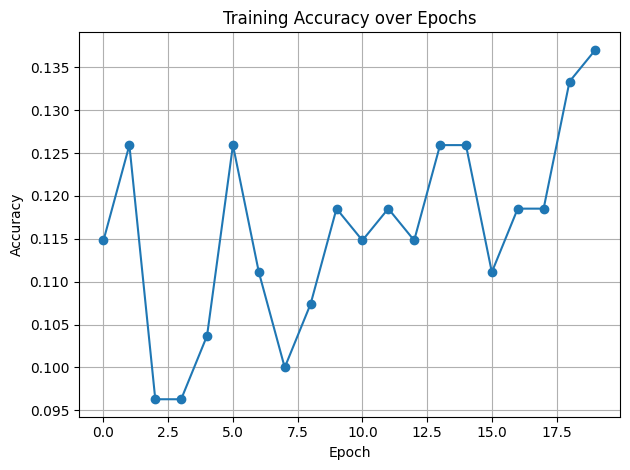

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate, functional as SF
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Assume your preprocessed data is loaded:
# X_train: [270, 12, 2600], y_train: [270]
# X_test: [370, 12, 2900], y_test: [370]
# Adjust time dimension length if necessary:
time_steps = 2600  # or the max sequence length used
X_train = X_train[:, :, :time_steps]
X_test = X_test[:, :, :time_steps]

# --- Input scaling to encourage spiking
X_train = X_train * 20.0
X_test = X_test * 20.0

# --- Dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# --- Model Definition
class SpeakerSNN(nn.Module):
    def __init__(self, beta=0.9, threshold=0.3, num_classes=9):
        super().__init__()
        self.conv1 = nn.Conv1d(12, 16, kernel_size=3, padding=1)
        self.lif1 = snn.Leaky(beta=beta, threshold=threshold, spike_grad=surrogate.fast_sigmoid())

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.lif2 = snn.Leaky(beta=beta, threshold=threshold, spike_grad=surrogate.fast_sigmoid())

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(32, num_classes)
        self.lif_out = snn.Leaky(beta=beta, threshold=threshold, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif_out.init_leaky()
        spk_out_rec = []

        for t in range(x.shape[2]):
            x_t = x[:, :, t].unsqueeze(-1)  # [B, 12, 1]
            c1 = self.conv1(x_t)
            spk1, mem1 = self.lif1(c1.squeeze(-1), mem1)

            c2 = self.conv2(spk1.unsqueeze(-1))
            spk2, mem2 = self.lif2(c2.squeeze(-1), mem2)

            pooled = self.pool(spk2.unsqueeze(-1)).squeeze(-1).squeeze(-1)
            pooled = self.dropout(pooled)
            out = self.fc(pooled)
            spk_out, mem3 = self.lif_out(out, mem3)

            spk_out_rec.append(spk_out)

        return torch.stack(spk_out_rec, dim=0)  # [T, B, C]

# --- Instantiate model
net = SpeakerSNN(num_classes=len(torch.unique(y_train))).to(device)

# --- Training setup
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = SF.ce_count_loss()
reg_lambda = 1e-4
num_epochs = 20

train_acc = []

# --- Training loop
for epoch in range(num_epochs):
    net.train()
    total, correct = 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        spk_out = net(x)  # [T, B, C]

        # Loss + regularization
        loss = loss_fn(spk_out, y) + reg_lambda * spk_out.sum()
        loss.backward()
        optimizer.step()

        # Prediction using average spike rate
        pred = spk_out.mean(0).argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    acc = correct / total
    train_acc.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Accuracy: {acc:.4f}")

# --- Evaluation loop
net.eval()
correct, total = 0, 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        spk_out = net(x)
        pred = spk_out.mean(0).argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

print(f"\nTest Accuracy: {correct / total:.4f}")

# --- Accuracy plot
plt.plot(train_acc, marker='o')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


Batch spike count: 79884.0
Batch spike count: 84378.0
Batch spike count: 76015.0
Batch spike count: 70486.0
Batch spike count: 67054.0
Batch spike count: 58325.0
Batch spike count: 50863.0
Batch spike count: 44598.0
Batch spike count: 17306.0
Epoch 1/20 - Train Acc: 0.1370
Epoch 2/20 - Train Acc: 0.0963
Epoch 3/20 - Train Acc: 0.1000
Epoch 4/20 - Train Acc: 0.0815
Epoch 5/20 - Train Acc: 0.1000
Epoch 6/20 - Train Acc: 0.0852
Epoch 7/20 - Train Acc: 0.1185
Epoch 8/20 - Train Acc: 0.1222
Epoch 9/20 - Train Acc: 0.1222
Epoch 10/20 - Train Acc: 0.0741
Epoch 11/20 - Train Acc: 0.0963
Epoch 12/20 - Train Acc: 0.1000
Epoch 13/20 - Train Acc: 0.1037
Epoch 14/20 - Train Acc: 0.1111
Epoch 15/20 - Train Acc: 0.0741
Epoch 16/20 - Train Acc: 0.1111
Epoch 17/20 - Train Acc: 0.0815
Epoch 18/20 - Train Acc: 0.1259
Epoch 19/20 - Train Acc: 0.1259
Epoch 20/20 - Train Acc: 0.1185

Test Accuracy: 0.0838


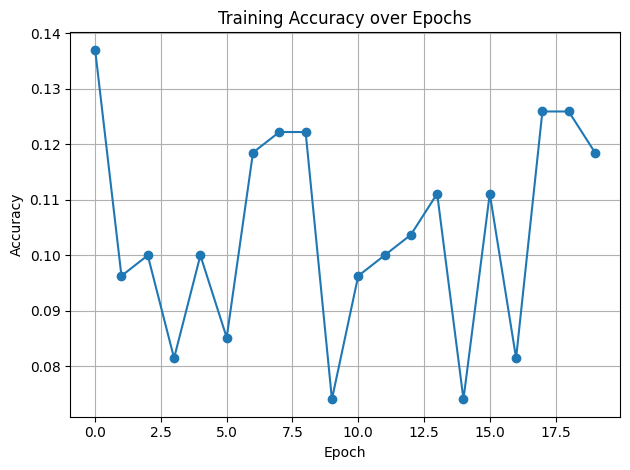

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate, functional as SF
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data scaling to ensure spikes
X_train = X_train * 20.0
X_test = X_test * 20.0

# Hyperparameters
batch_size = 32
num_epochs = 20
lr = 1e-3
beta = 0.7
threshold = 0.2
num_classes = len(torch.unique(y_train))

# Datasets and loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# SNN Model
class ConvSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=3, padding=1)
        self.lif1 = snn.Leaky(beta=beta, threshold=threshold, spike_grad=surrogate.fast_sigmoid())

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.lif2 = snn.Leaky(beta=beta, threshold=threshold, spike_grad=surrogate.fast_sigmoid())

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)
        self.lif_out = snn.Leaky(beta=beta, threshold=threshold, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif_out.init_leaky()
        spk_rec = []

        for t in range(x.shape[2]):
            x_t = x[:, :, t].unsqueeze(-1)  # [B, 12, 1]
            c1 = self.conv1(x_t)
            spk1, mem1 = self.lif1(c1.squeeze(-1), mem1)

            c2 = self.conv2(spk1.unsqueeze(-1))
            spk2, mem2 = self.lif2(c2.squeeze(-1), mem2)

            pooled = self.pool(spk2.unsqueeze(-1)).squeeze(-1).squeeze(-1)  # [B, 64]
            out = self.fc(pooled)
            spk_out, mem3 = self.lif_out(out, mem3)
            spk_rec.append(spk_out)

        return torch.stack(spk_rec, dim=0)  # [T, B, C]

# Instantiate model
net = ConvSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_fn = SF.ce_count_loss()

# Train
train_acc = []
for epoch in range(num_epochs):
    net.train()
    total, correct = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        spk_out = net(x)
        loss = loss_fn(spk_out, y)
        loss.backward()
        optimizer.step()

        pred = spk_out.sum(0).argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

        # Print spike stats (check nonzero)
        if epoch == 0:
            print("Batch spike count:", spk_out.sum().item())

    acc = correct / total
    train_acc.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {acc:.4f}")

# Evaluate
net.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        spk_out = net(x)
        pred = spk_out.sum(0).argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

print(f"\nTest Accuracy: {correct / total:.4f}")

# Plot
plt.plot(train_acc, marker='o')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
with torch.no_grad():
    x_test = torch.ones((1, 12, 1000)) * 20.0
    spk_out = net(x_test.to(device))
    print("Test spike count on dummy input:", spk_out.sum().item())

Test spike count on dummy input: 0.0


In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate, functional as SF
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 32
num_classes = len(torch.unique(y_train))  # Usually 9
num_epochs = 20
learning_rate = 1e-3
beta = 0.7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Optional: truncate to 1000 time steps
# X_train = X_train[:, :, :1000]
# X_test = X_test[:, :, :1000]
X_train = X_train * 10
X_test = X_test * 10

# Datasets and Dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ConvSNN Model
class ConvSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5, padding=2)
        self.lif1 = snn.Leaky(beta=0.7, threshold=0.2, spike_grad=surrogate.fast_sigmoid())

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.lif2 = snn.Leaky(beta=0.7, threshold=0.2, spike_grad=surrogate.fast_sigmoid())

        self.fc = nn.Linear(64, num_classes)
        self.lif_out = snn.Leaky(beta=0.7, threshold=0.2, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        # x: [batch, features=12, time]
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif_out.init_leaky()
        spk_out_rec = []

        for t in range(x.shape[2]):
            x_t = x[:, :, t].unsqueeze(2)  # [B, 12, 1]
            c1 = self.conv1(x_t)  # [B, 32, 1]
            s1, mem1 = self.lif1(c1.squeeze(2), mem1)  # [B, 32]

            c2 = self.conv2(s1.unsqueeze(2))  # [B, 64, 1]
            s2, mem2 = self.lif2(c2.squeeze(2), mem2)  # [B, 64]

            out = self.fc(s2)
            spk, mem3 = self.lif_out(out, mem3)  # [B, num_classes]
            spk_out_rec.append(spk)

        return torch.stack(spk_out_rec, dim=0)  # [T, B, C]

# Instantiate model
net = ConvSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = SF.ce_count_loss()

# Training loop
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    total, correct, train_loss = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        spk_out = net(x)  # [T, B, C]
        loss = loss_fn(spk_out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = spk_out.sum(0).max(1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
        print(f"Spike count: {spk_out.sum().item()}")

    acc = correct / total
    train_acc_list.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {acc:.4f}")

# Evaluation
net.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        spk_out = net(x)
        _, predicted = spk_out.sum(0).max(1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

print(f"\nTest Accuracy: {correct / total:.4f}")

# Plot training accuracy
plt.plot(train_acc_list, marker='o')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/20, Loss: 1319.7809, Accuracy: 0.0926
Epoch 2/20, Loss: 159.6987, Accuracy: 0.1111
Epoch 3/20, Loss: 28.1064, Accuracy: 0.1111
Epoch 4/20, Loss: 20.3374, Accuracy: 0.1037
Epoch 5/20, Loss: 19.9239, Accuracy: 0.1185
Epoch 6/20, Loss: 19.9795, Accuracy: 0.1074
Epoch 7/20, Loss: 19.8388, Accuracy: 0.1074
Epoch 8/20, Loss: 19.8010, Accuracy: 0.1074
Epoch 9/20, Loss: 19.8311, Accuracy: 0.1111
Epoch 10/20, Loss: 19.7750, Accuracy: 0.1111
Epoch 11/20, Loss: 19.7820, Accuracy: 0.1148
Epoch 12/20, Loss: 19.7686, Accuracy: 0.1148


KeyboardInterrupt: 

In [17]:
class DeepSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_features, 256)
        self.lif1 = snn.Leaky(beta=0.7, threshold=0.5, spike_grad=surrogate.fast_sigmoid())

        self.fc2 = nn.Linear(256, 128)
        self.lif2 = snn.Leaky(beta=0.7, threshold=0.5, spike_grad=surrogate.fast_sigmoid())

        self.fc3 = nn.Linear(128, num_classes)
        self.lif3 = snn.Leaky(beta=0.7, threshold=0.5, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk3_rec = []

        for step in range(x.size(2)):
            input_t = x[:, :, step]
            cur1 = self.fc1(input_t)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)

        return torch.stack(spk3_rec, dim=0)


### Old training code (not working)

In [ ]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF

# Parameters
beta = 0.9  # membrane decay
num_inputs = X_train.shape[1]  # 12
num_steps = X_train.shape[2]   # Tmax * 100
num_hidden = 100
num_outputs = 9

# Define the network
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        spk1_rec, mem1 = [], None
        spk2_rec, mem2 = [], None

        for step in range(x.size(2)):  # Loop through time steps
            input_t = x[:, :, step]
            cur1 = self.fc1(input_t)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)

        return torch.stack(spk2_rec, dim=0)

model = SNN()


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = SF.mse_count_loss(correct_rate=True)

for epoch in range(10):
    for batch in train_loader:
        x, y = batch
        spk_out = model(x)
        loss_val = loss_fn(spk_out, y)
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)
        optimizer.step()
    print(f"Epoch {epoch}: loss = {loss_val.item():.4f}")

In [ ]:
def evaluate(model, loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            spk_out = model(x)
            spk_count = spk_out.sum(dim=0)  # Sum over time
            preds = spk_count.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

acc = evaluate(model, test_loader)
print(f"Test Accuracy: {acc * 100:.2f}%")
